In [1]:
import sys,os
import glob
import torch,dill
import torchvision.utils as vutils
import matplotlib.pyplot as plt
#from iresnet import iResBlock
#from iEluNetwork import iConv2d
#from spectral_norm import SN
import numpy as np
import seaborn as sb
import torch.nn.functional as F
import pandas as pd
import flow_ssl

In [10]:
import os
import torch
import torch.nn as nn
from oil.datasetup.datasets import CIFAR10,CIFAR100
from oil.model_trainers.classifier import Classifier,simpleClassifierTrial
# from resnets import SplitODEResnet,ODEResnet,LongResnet,RNNBottle
# from resnets import SmallResnet,RNNResnet
from oil.tuning.study import Study, train_trial
from oil.utils.utils import Named,Expression
from flow_ssl.invertible import iConv2d,iSLReLU,SqueezeLayer,ClippediConv2d,iSequential,ActNorm
from flow_ssl.invertible import SqueezeLayer,padChannels,keepChannels,NNdownsample,iAvgPool2d,Flatten,iLeakyReLU
from flow_ssl.invertible import iLogits, iBN, MeanOnlyBN, passThrough, addZslot, Join, pad_circular_nd
from flow_ssl.icnn.icnn import StandardNormal,FlowNetwork
# from oil.tuning.configGenerator import uniform,logUniform

# log_dir_base = os.path.expanduser('~/tb-experiments/degradation_test')
# cfg_spec = {
#     'dataset': CIFAR10,
#     'network': [DegredationTester],
#     'net_config': [ {},
#                     {'circ':True},
#                     {'circ':True,'slrelu':True},
#                     {'circ':True,'slrelu':True,'ds':'checkerboard'},
#                     {'circ':True,'slrelu':True,'ds':'nn'},
#                     {'circ':True,'slrelu':True,'ds':'avg'},
#                     ],#k=128
#     'loader_config': {'amnt_dev':0,'lab_BS':50},
#     'opt_config':{'lr':.1},
#     'num_epochs':100, 
#     'trainer_config':{'log_dir':lambda cfg:log_dir_base+\
#         '/{}/{}'.format(cfg['dataset'],cfg['network'])}
#     }
#'log_dir':lambda cfg:f'{log_dir_base}/{cfg['dataset']}/{cfg['network']}/s{cfg['net_config']['sigma']}'
#ODEResnet,RNNResnet,,SplitODEResnet,SmallResnet,BezierRNNSplit,BezierODE,BezierRNN
class DegredationTester(FlowNetwork):
    def __init__(self, num_classes=10,k=64,circ=False,slrelu=False,lrelu=None,bn=True,clip=(.01,None),ds='max'):
        super().__init__()
        self.num_classes = num_classes
        self.k = k
        
        conv = lambda c1,c2: iConv2d(c1,c2,circ=circ)#ClippediConv2d(c1,c2,clip=clip,circ=circ)#iConv2d(c1,c2,circ=circ)#ClippediConv2d(c1,c2,clip=clip,circ=circ)#iConv2d(c1,c2,circ=circ)
        BN = iBN if bn else lambda c: Id()#ActNorm##lambda c: nn.BatchNorm2d(c)#Expression(lambda x:x)#nn.BatchNorm2d(c)#Expression(lambda x:x)#nn.Sequential()#nn.BatchNorm2d#ActNorm#nn.BatchNorm2d
        relu = iSLReLU if slrelu else nn.ReLU
        if lrelu is not None: relu = lambda: iLeakyReLU(lrelu)
        if ds=='max': downsample = lambda: nn.MaxPool2d(2)
        elif ds=='checkerboard': downsample = lambda: SqueezeLayer(2)
        elif ds=='nn': downsample = lambda: NNdownsample()
        elif ds=='avg': downsample = lambda: iAvgPool2d()
        else: assert False, "unknown option"
        CBR = lambda c1,c2: iSequential(conv(c1,c2),BN(c2),relu())
        self.body = iSequential(
            padChannels(k-3),
            addZslot(),
            passThrough(*[CBR(k,k) for _ in range(3)]),
            passThrough(downsample()),
            keepChannels(2*k),
            passThrough(*[CBR(2*k,2*k) for _ in range(3)]),
            passThrough(downsample()),
            keepChannels(2*k),
            passThrough(*[CBR(2*k,2*k) for _ in range(3)]),
            Join()
        )
        self.classifier_head = nn.Sequential(
            Expression(lambda z:z[-1]),
            Expression(lambda u:u.mean(-1).mean(-1)),
            nn.BatchNorm1d(2*k),
            nn.Linear(2*k,num_classes)
        )
        self.flow = iSequential(iLogits(),self.body,Flatten())
        self.prior = StandardNormal(k*32*32)

In [52]:
paths = glob.glob(os.path.expanduser('~/tb-experiments/iresnet_WTW/**/*.trainer'),recursive=True)
elu_paths = glob.glob(os.path.expanduser('~/tb-experiments/icnn_repro_nobn/**/*.trainer'),recursive=True)
#elu_paths = glob.glob(os.path.expanduser('~/tb-experiments/iCNN/**/*.trainer'),recursive=True)
elu_paths = glob.glob(os.path.expanduser('~/tb-experiments/multiscale_icnnv2_ld/**/*.trainer'),recursive=True)
paths = elu_paths
print(paths)
trainer = torch.load(paths[-1],pickle_module=dill)
trainer.model.eval();

['/home/marc/tb-experiments/multiscale_icnnv2_ld/CIFAR10/MultiScaleiCNNv2/trial0/checkpoints/c1.trainer']


In [ ]:
# def change_tol(module):
#     if isinstance(module,iResBlock):
#         module.inverse_tol=1e-10
#         print(module.iters_per_reverse)
#     if isinstance(module,SN):
#         print(module._s)
#     if isinstance(module,iConv2d):
#         print(module._reverse_iters)
#         try: print(module.iters_per_reverse)
#         except ZeroDivisionError: pass
# trainer.model.apply(change_tol);

In [ ]:
zs = []
with torch.no_grad():
    for mb in trainer.dataloaders['train']:
        z = trainer.model.get_all_z_squashed(mb[0]).reshape(mb[0].shape[0],-1).cpu().data.numpy()
        zs.append(z)
        if len(zs) > 100: break


In [ ]:
Zs = np.concatenate(zs)

In [ ]:
Zs.shape

In [ ]:
#sb.distplot(Zs[:,0])
for i in range(10):
    sb.distplot(Zs[:,i]+1*i,kde=False,label=i)
#plt.yscale('log')
#plt.xscale('log')
#plt.legend()

In [ ]:
def get_nlls(dataloader):
    nlls = []
    with torch.no_grad():
        for mb in dataloader:
            nlls.append(trainer.model.nll(mb[0]).cpu().data.numpy())
    return np.concatenate(nlls)

In [ ]:
from oil.datasetup.datasets import CIFAR10,CIFAR100,SVHN
from torch.utils.data import DataLoader
from oil.utils.utils import LoaderTo

In [ ]:
C100,SVHN_ = [dataset(f'~/datasets/{dataset}/',flow=True) for dataset in (CIFAR100,SVHN)]
C100L,SVHNL =  [LoaderTo(DataLoader(data,batch_size=50,shuffle=False),torch.device('cuda')) for data in (C100,SVHN_)]

In [ ]:
for mb in C100L:
    break
#mb[0]
plt.hist(mb[0].reshape(-1).cpu().data.numpy())

In [ ]:
#train_nlls = get_nlls(trainer.dataloaders['train'])
#dev_nlls = get_nlls(trainer.dataloaders['dev'])
C100_nlls = get_nlls(C100L)
SVHN_nlls = get_nlls(SVHNL)

In [ ]:
sb.distplot(train_nlls)
sb.distplot(dev_nlls)
sb.distplot(C100_nlls)
sb.distplot(SVHN_nlls)
plt.xlim(-10000,0)
plt.legend(["train","dev","CIFAR100","SVHN"])

In [60]:
from copy import deepcopy
for mb in trainer.dataloaders['dev']:
    break
inp =x=mb[0]
trainer.model.eval();
model = trainer.model[1]
with torch.no_grad():
    output = model.body[:17](inp)
    inp_rec = model.body[:17].inverse(deepcopy(output))
print((inp_rec - inp).norm()/(inp).norm())

tensor(0.1831, device='cuda:0')


In [30]:
model.body

iSequential(
  (0): iLogits()
  (1): RandomPadChannels()
  (2): addZslot()
  (3): iSequential(
    (0): both(
      (module1): iConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (module2): Id()
    )
    (1): both(
      (module1): iSLReLU()
      (module2): Id()
    )
  )
  (4): iSequential(
    (0): both(
      (module1): iConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (module2): Id()
    )
    (1): both(
      (module1): iSLReLU()
      (module2): Id()
    )
  )
  (5): iSequential(
    (0): both(
      (module1): iConv2d(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (module2): Id()
    )
    (1): both(
      (module1): iSLReLU()
      (module2): Id()
    )
  )
  (6): iSequential(
    (0): both(
      (module1): NNdownsample()
      (module2): Id()
    )
  )
  (7): iSequential(
    (0): both(
      (module1): iConv1x1(256, 2

In [17]:
from flow_ssl.invertible import FlatJoin

with torch.no_grad():
    output2 = trainer.model[1].body[5](output)
    inp_rec2 = trainer.model[1].body[5].inverse(deepcopy(output2))
#print(len(output2),len(inp_rec2))
FJ = FlatJoin()
#print(FJ(output).shape,FJ(output2).shape,FJ(inp_rec2).shape)
((FJ(deepcopy(inp_rec2)) - FJ(deepcopy(output))).norm()/(FJ(deepcopy(output))).norm())

TypeError: 'MultiScaleiCNNv2' object does not support indexing

In [ ]:
plt.hist(inp_rec2[0].cpu().data.numpy().reshape(-1),alpha=.5)
plt.hist(output[0].cpu().data.numpy().reshape(-1),alpha=.5)

In [ ]:
inp_rec = trainer.model[1].body[:5].inverse(deepcopy(inp_rec2))
print((inp_rec - inp).norm()/(inp).norm())

In [ ]:
trainer.model[1].body[5]

In [ ]:
((inp_rec - inp).norm()/(inp).norm())

In [ ]:
for module in trainer.model.body._modules.values():
    print(module)

In [ ]:
trainer.model.logdet()

In [ ]:
%debug

In [ ]:
x = np.linspace(-10,5,100)
beta = .1
alpha = (1-beta)/(1+beta)
elu = lambda x: (x>=0)*x +  (x<0)*(np.exp(x)-1)
lelu = lambda x: (x+alpha*(np.sqrt(1+x**2)-1))/(1+alpha)
leakyrelu = lambda x: (x>=0)*x +  (x<0)*.1*x

In [ ]:
plt.plot(x,elu(x))
plt.plot(x,lelu(x))
plt.plot(x,leakyrelu(x))
plt.legend(["elu",r"smooth lrelu = $(x+\alpha*(\sqrt{1+x^2}-1))/(1+\alpha)$",r"Leaky Relu $\beta = .1$"])

In [ ]:
def slrelu_inverse(y,a):
    b = (1+a)*y + a
    x = (np.sqrt(a**2 + (a*b)**2-a**4) - b)/(a**2-1)
    return x

In [ ]:
plt.plot(x,slrelu_inverse(lelu(x),alpha))

In [ ]:
inp_rec.shape

In [ ]:
plt.imshow(inp_rec[0].cpu().data.numpy().transpose((1,2,0)))
plt.show()
plt.imshow(inp[0].cpu().data.numpy().transpose((1,2,0)))
plt.show()

In [ ]:
((inp_rec - inp).norm()/(inp[0]).norm())

In [ ]:
plt.hist(output.cpu().numpy().reshape(-1))

In [ ]:
with torch.no_grad():
    output = trainer.model[1].body(inp)

In [ ]:
trainer.model.eval()
with torch.no_grad():
    sampled_imgs = trainer.model.sample(32).cpu().data

In [ ]:
sampled_imgs

In [ ]:
grid = vutils.make_grid(sampled_imgs, normalize=True)
plt.imshow(grid.permute(1,2,0))

In [ ]:
grid.shape

In [ ]:
list(z_.shape for z_ in output)

In [ ]:
with torch.no_grad():
    inp_reconstructed = trainer.model[1].body.inverse(output);

In [ ]:
((inp_reconstructed[0] - inp[0]).norm()/(inp[0]).norm())

In [ ]:
plt.hist(inp_rec[0].cpu().data.numpy().reshape(-1),alpha=.5)
plt.hist(inp[0].cpu().data.numpy().reshape(-1),alpha=.5)

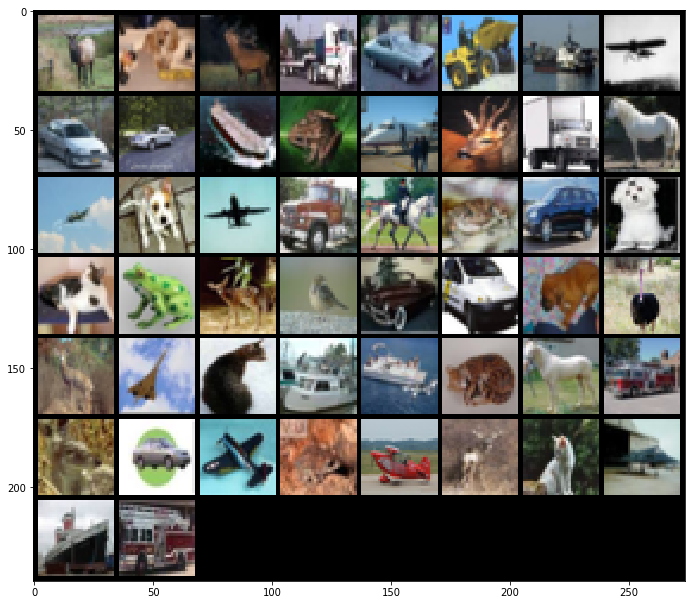

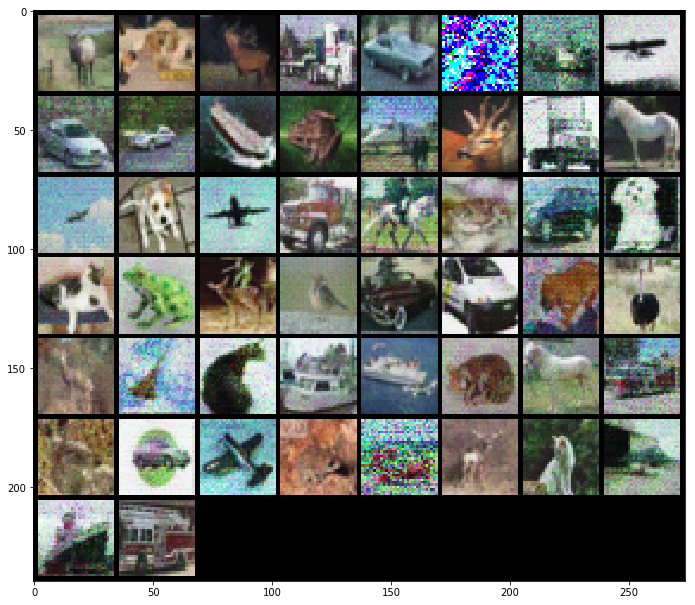

In [61]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
#print(y.shape)
grid = vutils.make_grid(mb[0]).cpu().data.numpy().transpose(1,2,0)
plt.imshow(grid)
plt.show()
grid = vutils.make_grid(inp_rec).cpu().data.numpy().transpose(1,2,0)
plt.imshow(grid)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

In [ ]:
for zi in z: print(zi.shape)

In [ ]:
import torch
from downsample import SqueezeLayer
from downsample import NNdownsample,iAvgPool2d

In [ ]:
S = SqueezeLayer(2)

In [ ]:
x = torch.Tensor([0,1,2,3,4,5,6,7]).reshape(1,2,2,2)

In [ ]:
S(x)

In [ ]:
x

In [ ]:
z = S(x-F.interpolate(F.interpolate(x,scale_factor=1/2),scale_factor=2))

In [ ]:
S2 = iAvgPool2d()#NNdownsample()

In [ ]:
x

In [ ]:
S2.inverse(S2(x))

In [ ]:
S2(x)